In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Outlier_detection" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train
from Data_handling.RealNVP import FlowGMM

os.chdir("Outlier_detection")
os.getcwd()

KeyboardInterrupt: 

# Import
First we import the necessary data for the model. The data we take will be the main sequence of our original cluster we did the cluster assignment probability on.

In [ ]:
os.chdir("../cluster_files")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../Outlier_detection")

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/3849262756.py:2: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_df=pd.read_csv('cluster_members_final.csv')


# Cluster Members from Previous Assignment

1. We will begin by taking a look at the main sequence only.   
2. We will not include error at the outset
3. We will just use Gaia mag and colour. Others will be more useful.


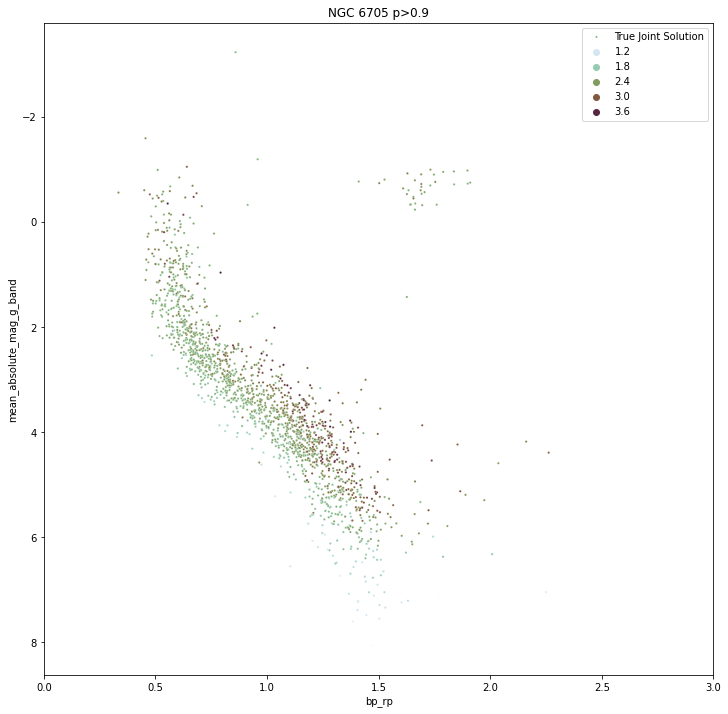

In [ ]:
probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)
scatter=cluster_df[cluster_df[probability]>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.xlim(0,3)
plt.show()

We next take away erroneous values

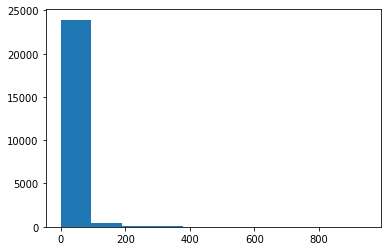

In [ ]:
cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
plt.hist(cluster_df['phot_bp_mean_flux_error'])
plt.show()

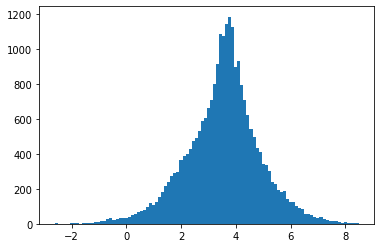

In [ ]:
plt.hist(cluster_df['mean_absolute_mag_g_band'],bins=100)
plt.show()

# The distance cuts 

1. We will take off obvious distance outliers.
2. We will then assign all cluster members to be at the same distance.

<AxesSubplot:xlabel='rgeo', ylabel='Count'>

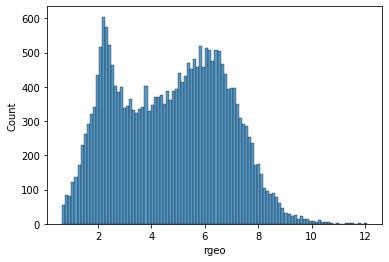

In [ ]:
sn.histplot(data=cluster_df,x='rgeo',bins=100)

In [ ]:
scatter=cluster_df[cluster_df[probability]>0.9]
orig_scatter=cluster_df[cluster_df[probability]>0.9]

In [ ]:
scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

# Commentary on the Isochrone we Use Later. 

1. We have set the extinction later in our isochrone. 
2. We then took the distance to be 1.9kpc, even though that is quite different to what my value says from computation. The reason for this is that it and the gaussian process lines up well with the isochrone from cantat gaudin


In [ ]:
scatter['rgeo']=scatter['rgeo'].median()
orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
scatter['rgeo']=2.0
orig_scatter['rgeo']=2.0
def mean_basolute_mag_g_band(selection_gaia):
    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo']*1000)+5   #parsec
    return selection_gaia
mean_basolute_mag_g_band(scatter)
mean_basolute_mag_g_band(orig_scatter)

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/4208601668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/4208601668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_scatter['rgeo']=2.0
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/4208601668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

,Unnamed: 0.1,index,ra,dec,rgeo,VRAD,pmra,pmdec,prob,level_0,...,mean_absolute_mag_g_band,prob_other,labels,0,1,2,p1,p2,p3,p4
8,8,8,282.605871,-6.285981,2.0,35.82000,-1.524832,-4.087407,0.998780,8,...,4.898970,0.999761,-1,0.893085,0.061897,0.045018,2.521699e-246,0.000053,0.999927,0.000021
11,11,11,282.610660,-6.223920,2.0,34.88000,-1.473501,-4.048390,0.997926,11,...,4.446898,0.999636,-1,0.872479,0.072215,0.055305,1.145480e-255,0.000100,0.999848,0.000052
12,12,12,282.610679,-6.250028,2.0,38.06000,-1.426512,-4.110239,0.998425,12,...,4.613659,0.999707,-1,0.886735,0.065096,0.048169,0.000000e+00,0.000069,0.999899,0.000031
16,16,16,282.615905,-6.195400,2.0,35.33000,-1.635095,-4.333528,0.997369,16,...,5.232925,0.999676,-1,0.810900,0.101568,0.087531,0.000000e+00,0.000195,0.999692,0.000113
18,18,18,282.617394,-6.285022,2.0,38.54000,-1.650539,-4.066653,0.997315,18,...,3.080551,0.999498,-1,0.945871,0.033301,0.020828,3.103372e-305,0.000050,0.999923,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24310,25529,25529,282.844474,-6.035441,2.0,0.00000,-1.771043,-3.786812,0.657901,24555,...,5.873634,0.937534,-1,0.828466,0.093317,0.078217,1.840654e-05,0.033867,0.948918,0.017196
24358,25579,25579,282.856958,-6.023364,2.0,36.96674,-1.475075,-4.335688,0.959280,24605,...,-1.056925,0.990815,-1,0.990951,0.006288,0.002761,0.000000e+00,0.000153,0.999806,0.000041
24456,25683,25683,282.723210,-6.035772,2.0,0.00000,-1.443794,-3.795102,0.871778,24709,...,6.272660,0.980037,-1,0.744784,0.131517,0.123699,1.803018e-05,0.013396,0.975419,0.011166
24495,25725,25725,282.781765,-6.019287,2.0,0.00000,-1.572531,-4.036875,0.900781,24751,...,4.432134,0.976854,-1,0.799145,0.107023,0.093832,9.318611e-06,0.007226,0.986347,0.006418


# So far
We have assumed that everything is at the same distance. Moreover, we are going to make cuts ont he absolute magnitude to get ride of sources outside the main sequence.

In [ ]:
scatter=scatter[scatter.mean_absolute_mag_g_band>0.0].reset_index(drop=True)

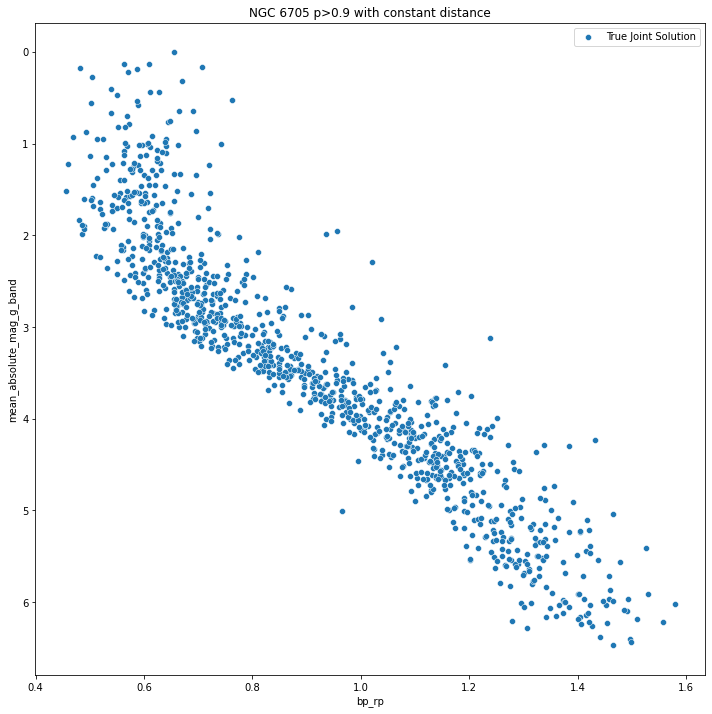

In [ ]:

probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)


sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Joint Solution')
axes.invert_yaxis()
#axes.set_xlim(0,2.5)
plt.legend()
axes.set_title("NGC 6705 p>0.9 with constant distance")

plt.show()

### Order the data by the absolute magnitude so that its a function.

In [ ]:
scatter=scatter.sort_values(by=['mean_absolute_mag_g_band'])
orig_scatter=orig_scatter.sort_values(by=['mean_absolute_mag_g_band'])

# Gaussian Process
We will define a gaussian process on the data from the absolute magnitude to the colour.

In [ ]:
import gpytorch

import torch
input_data=torch.Tensor(scatter[['bp_rp','mean_absolute_mag_g_band']].values.astype(float).transpose())

In [ ]:
train_x=input_data[0]
train_y=input_data[1]

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(has_lengthscale=True,lengthscale_constraint=gpytorch.constraints.Interval(1e-4,0.9)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
train_x=input_data[1]
train_y=input_data[0]
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x,train_y, likelihood)

In [ ]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [ ]:
training_iter=200

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
        
    ))
    optimizer.step()


Iter 1/200 - Loss: 0.771   lengthscale: 0.450   noise: 0.693
Iter 2/200 - Loss: 0.732   lengthscale: 0.473   noise: 0.644
Iter 3/200 - Loss: 0.693   lengthscale: 0.495   noise: 0.598
Iter 4/200 - Loss: 0.656   lengthscale: 0.516   noise: 0.554
Iter 5/200 - Loss: 0.621   lengthscale: 0.538   noise: 0.513
Iter 6/200 - Loss: 0.578   lengthscale: 0.558   noise: 0.474
Iter 7/200 - Loss: 0.534   lengthscale: 0.578   noise: 0.437
Iter 8/200 - Loss: 0.495   lengthscale: 0.597   noise: 0.403
Iter 9/200 - Loss: 0.447   lengthscale: 0.615   noise: 0.370
Iter 10/200 - Loss: 0.410   lengthscale: 0.632   noise: 0.340
Iter 11/200 - Loss: 0.363   lengthscale: 0.648   noise: 0.312
Iter 12/200 - Loss: 0.320   lengthscale: 0.663   noise: 0.286
Iter 13/200 - Loss: 0.284   lengthscale: 0.677   noise: 0.261
Iter 14/200 - Loss: 0.238   lengthscale: 0.691   noise: 0.239
Iter 15/200 - Loss: 0.191   lengthscale: 0.703   noise: 0.218
Iter 16/200 - Loss: 0.145   lengthscale: 0.715   noise: 0.199
Iter 17/200 - Los

### Once we have trained our GP we will evaluate the model on the trained data.

In [ ]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [ ]:
'''
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10,10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train_x.numpy(), train_y.numpy(),s=10)
    # Plot predictive means as blue line
    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.invert_yaxis()
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')'''

"\nwith torch.no_grad():\n    # Initialize plot\n    f, ax = plt.subplots(1, 1, figsize=(10,10))\n\n    # Get upper and lower confidence bounds\n    lower, upper = observed_pred.confidence_region()\n    # Plot training data as black stars\n    ax.scatter(train_x.numpy(), train_y.numpy(),s=10)\n    # Plot predictive means as blue line\n    ax.plot(train_x.numpy(), observed_pred.mean.numpy(), 'r')\n    # Shade between the lower and upper confidence bounds\n    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)\n    \n    ax.invert_yaxis()\n    ax.legend(['Observed Data', 'Mean', 'Confidence'])\n    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')"

# HR diagram

We will analyse the fit of the GP to the HR diagram

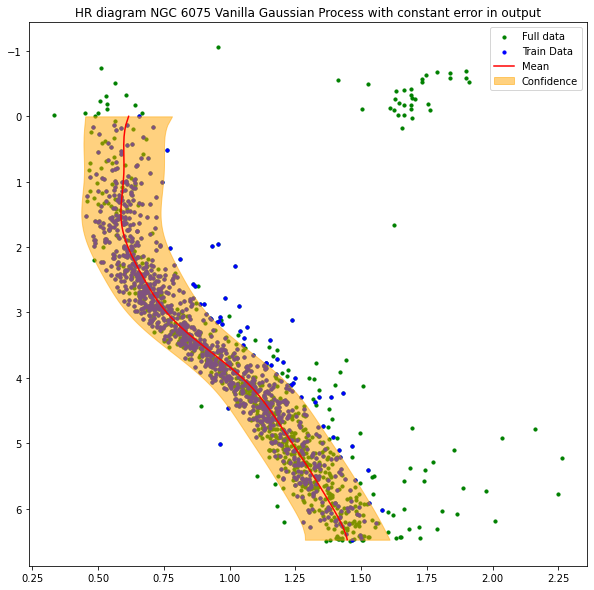

In [ ]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10,10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
    ax.scatter(train_y.numpy(),train_x.numpy() ,s=10,color='blue')
    
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.numpy(),train_x.numpy(),  'r')

    # Shade between the lower and upper confidence bounds
    ax.fill_betweenx(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5,color='orange')
    
    ax.invert_yaxis()
    ax.legend(['Full data','Train Data', 'Mean', 'Confidence'])
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

# Isochrone

We are now going to import our isochrone using the MIST isochrone fitting software. We found the values for M11 cluster from literature.

In [ ]:
import pandas as pd
os.chdir('../Cluster_analysis')
columns=[str(i) for i in range (34)]
iso=pd.read_csv('iso.txt',delim_whitespace=True, names=columns)
isochrone=pd.DataFrame(iso[['0','22','23','24']].values[1:],columns=iso[['0','22','23','24']].values[0]).astype(float)

In [ ]:
isochrone['BPRP']=isochrone['Gaia_BP_DR2Rev']-isochrone['Gaia_RP_DR2Rev']

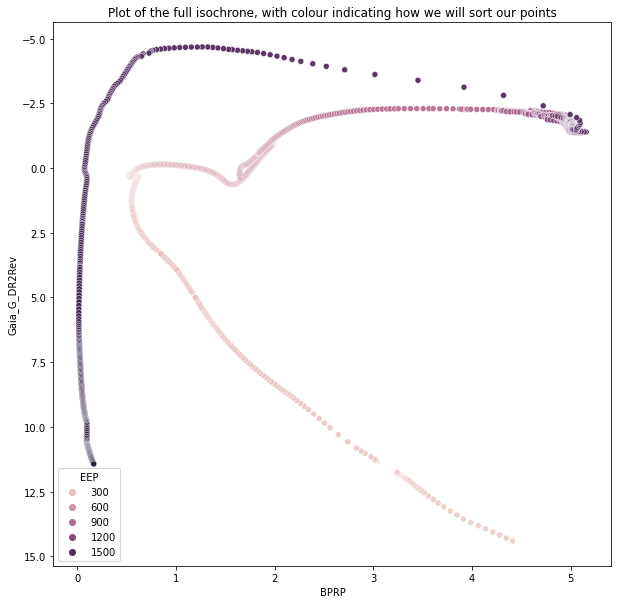

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))

sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',hue='EEP',color='r')
plt.title('Plot of the full isochrone, with colour indicating how we will sort our points')
ax.invert_yaxis()

# HR diagram with isochone plot

Extinction
1.24
feh=0.17
age 316e6 year

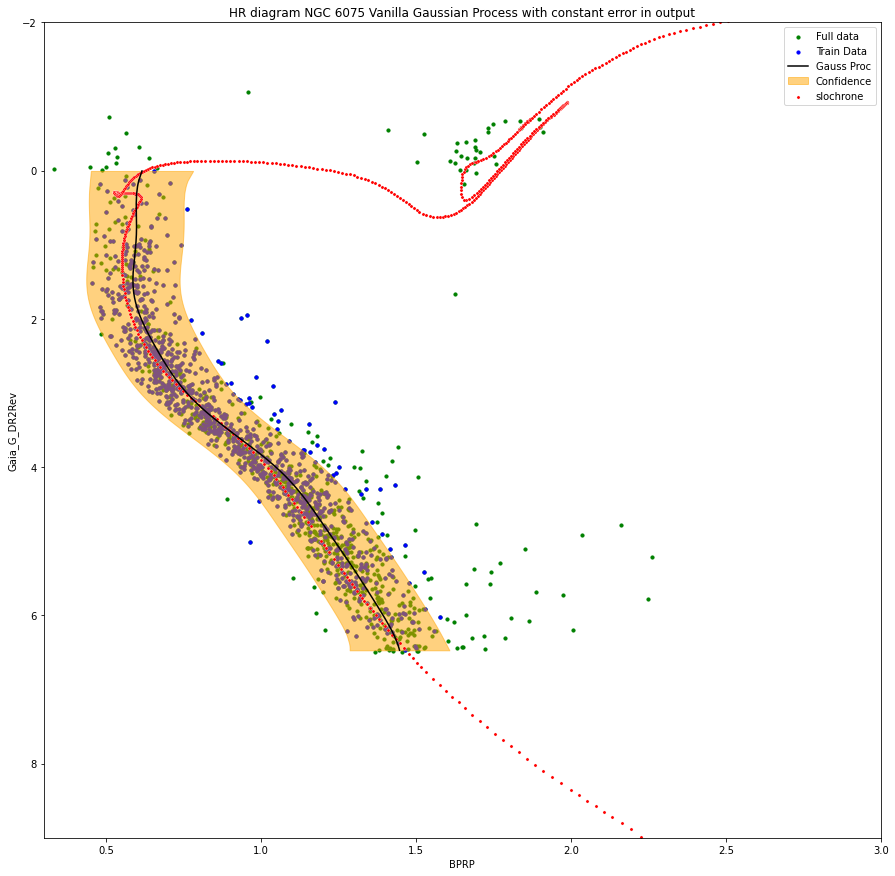

In [ ]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15,15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #
    ax.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
    ax.scatter(train_y.numpy(),train_x.numpy() ,s=10,color='blue')
    
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.numpy(),train_x.numpy(),  'black')

    # Shade between the lower and upper confidence bounds
    ax.fill_betweenx(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5,color='orange')
    sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='r',ax=ax,s=10)
    ax.set_ylim(-2.0,9)
    
    ax.legend(['Full data','Train Data', 'Gauss Proc', 'Confidence','sIochrone'])
    ax.invert_yaxis()
    ax.set_xlim(0.3,3)
    
    
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

# Change isochrone so within desired range of main sequence.

In [ ]:
isochrone=isochrone[isochrone['BPRP']<1.6].reset_index(drop=True)
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']>1.0].reset_index(drop=True)
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']<6.5].reset_index(drop=True)


In [ ]:
isochrone=isochrone.sort_values(by='EEP').reset_index(drop=True)

In [ ]:
#Take every third value
isochrone=isochrone.iloc()[::3,:].reset_index(drop=True)

# Perpendicular distributions
We construct approximate local tangent spaces around the curve and analyse the distribution projected onto the perpendicular axis.

In [ ]:
p_slopes=[]

x=isochrone['BPRP']
y=isochrone['Gaia_G_DR2Rev']
for i in range(len(isochrone)-1):    
    dy=y[i+1]-y[i]
    dx=x[i+1]-x[i]
    p_slopes.append(-1*dx/dy)
p_slopes.append(0)

In [ ]:
isochrone['p_slopes']=p_slopes
isochrone['slopes']=-1/isochrone['p_slopes']

In [ ]:
high_c=[]
low_c=[]
for i in range(len(isochrone)-1):
    high_c.append(isochrone['Gaia_G_DR2Rev'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
    low_c.append(isochrone['Gaia_G_DR2Rev'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
high_c.append(0)
low_c.append(0)

In [ ]:
isochrone['low_c']=high_c #high c is low c oops
isochrone['high_c']=low_c

In [ ]:
isochrone=isochrone.loc()[0:len(isochrone)-2]

# Now we do a sample of the projection of the distribution

In [ ]:
i=18
x=(orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i])
y=(isochrone['low_c'][i]<=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i])

In [ ]:
test=orig_scatter[x]
test2=test[y]
len(test2)

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/3457793293.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test2=test[y]


88

# HR diagram plot showing the distribution of points in the approcimate tangent space.

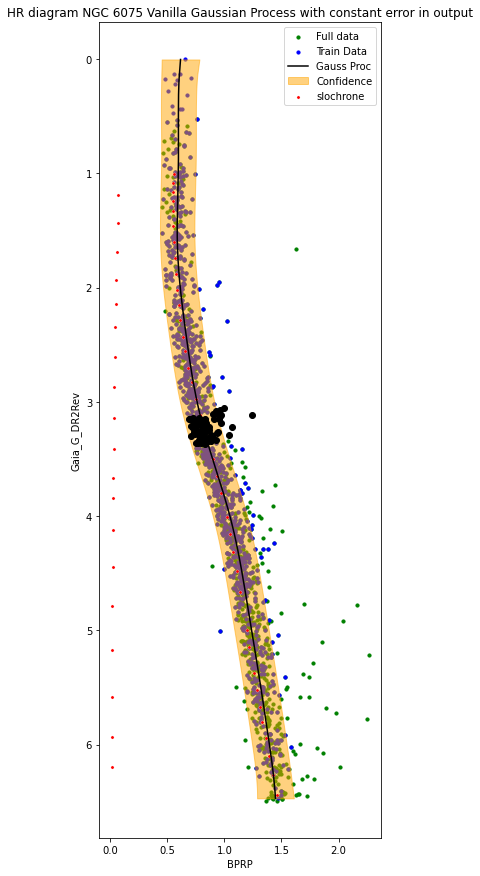

In [ ]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15,15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #
    ax.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
    ax.scatter(train_y.numpy(),train_x.numpy() ,s=10,color='blue')
    
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.numpy(),train_x.numpy(),  'black')

    # Shade between the lower and upper confidence bounds
    ax.fill_betweenx(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5,color='orange')
    sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='r',ax=ax,s=10)
    #ax.set_ylim(-2.0,9)
    ax.scatter(test2['bp_rp'],test2['mean_absolute_mag_g_band'],color='black')
    ax.legend(['Full data','Train Data', 'Gauss Proc', 'Confidence','sIochrone'])
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    #ax.set_xlim(0.3,3)
    
    
    
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

# Projeting to the perpendicular axis.

In [ ]:
center=isochrone['Gaia_G_DR2Rev'][i] - isochrone['slopes'][i]*isochrone['BPRP'][i]
test2['proj']=test2['mean_absolute_mag_g_band']-test2['bp_rp']*isochrone['slopes'][i]

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/875763399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['proj']=test2['mean_absolute_mag_g_band']-test2['bp_rp']*isochrone['slopes'][i]


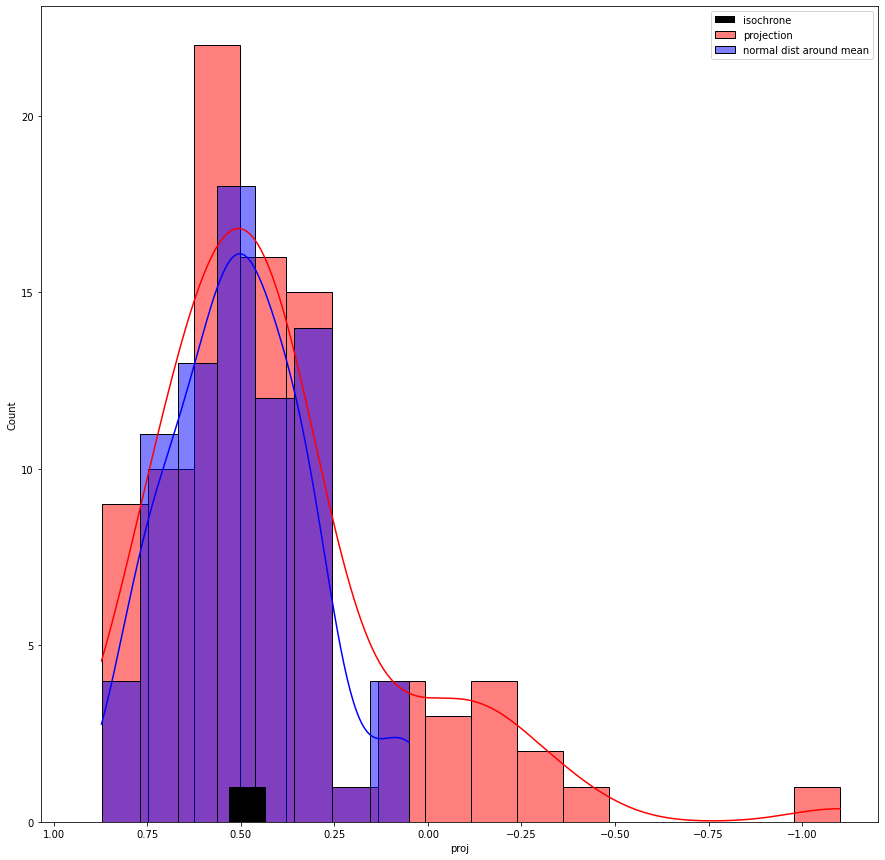

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(15,15))
sn.histplot(test2['proj'],kde=True,label='projection',ax=ax,color='red')

sn.histplot(test2[test2['proj']>0]['proj'],label='normal dist around mean',color='blue',kde=True,ax=ax)
ax.hist(center,color='black',label='isochrone')
ax.invert_xaxis()
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

# Now we look at all the local tangent space distributions along the isochrone. We will do a standard scaler transformation so that we can compare each one. (is this okay for this problem)

In [ ]:
centers=[]
tests=[]
for i in range(35):
    try:
        x=(orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i])
        y=(isochrone['low_c'][i]<=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i])

        test=orig_scatter[x]
        test=test[y]

        center=isochrone['Gaia_G_DR2Rev'][i] - isochrone['slopes'][i]*isochrone['BPRP'][i]
        test['proj']=test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]

        centers.append(center)
        tests.append(scaler.fit_transform(test['proj'].values.reshape(-1,1)))
    except:
        continue
        print(i)
    

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/1761851543.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test=test[y]
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/1761851543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['proj']=test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/1761851543.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test=test[y]
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_3797/1761851543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [ ]:
flat_test=[j for sublist in tests for j in sublist]
flat_test=np.array(flat_test).reshape(len(flat_test))

# Distribution

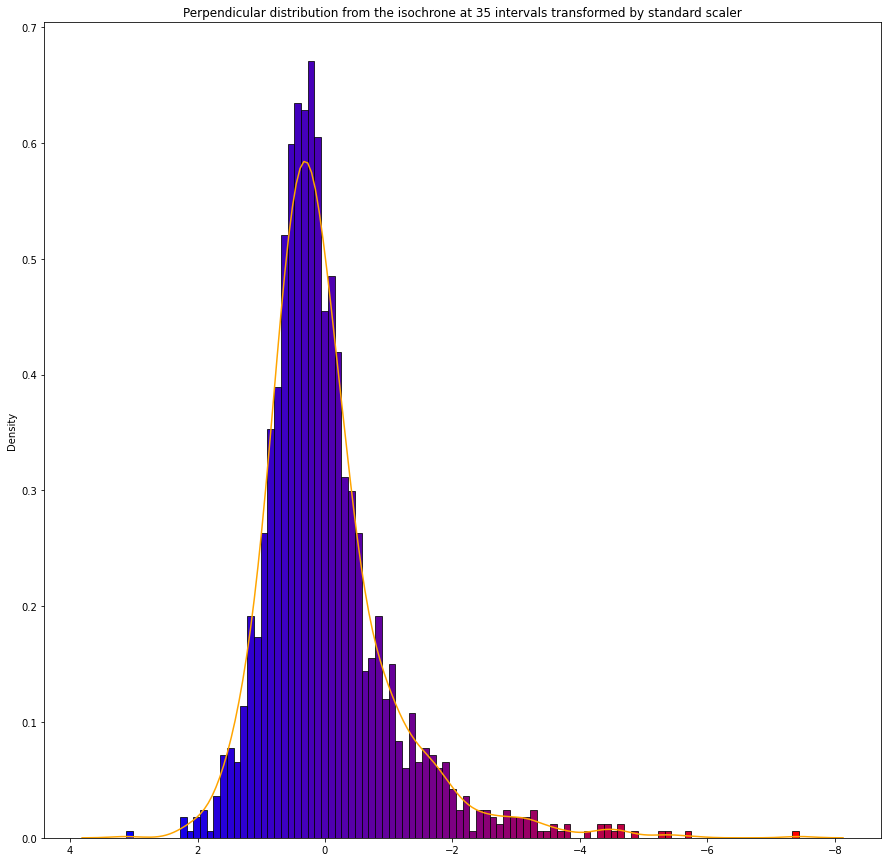

In [ ]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(flat_test,ax=ax,kde=False,legend=False,bins=100,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(flat_test,ax=ax,color='orange')
ax.invert_xaxis()
plt.show()

# Anything Binary?

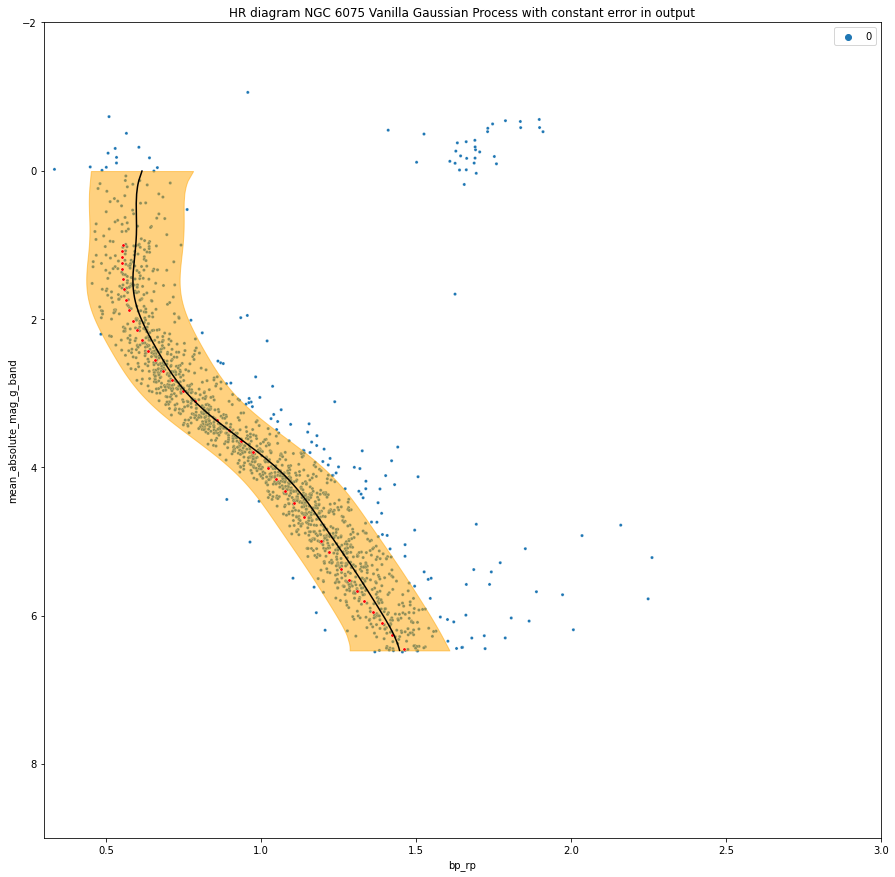

In [ ]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15,15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #
    sn.scatterplot(data=orig_scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='non_single_star',s=10)
    #ax.scatter(train_y.numpy(),train_x.numpy() ,s=10,color='blue')
    
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.numpy(),train_x.numpy(),  'black')

    # Shade between the lower and upper confidence bounds
    ax.fill_betweenx(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5,color='orange')
    sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='r',ax=ax,s=10)
    ax.set_ylim(-2.0,9)
    
    #ax.legend(['Full data','Train Data', 'Gauss Proc', 'Confidence','sIochrone'])
    ax.invert_yaxis()
    ax.set_xlim(0.3,3)
    
    
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

# Now see how this changes per angle

# make cut on original scatter

In [ ]:
orig_scatter=orig_scatter[orig_scatter['mean_absolute_mag_g_band']>0.5].reset_index(drop=True)

In [ ]:
import math
centers=[]
tests=[]
theta=90
for i in range(360):
    try:


        
        test=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*(math.tan(i))

        centers.append(center)
        tests.append(scaler.fit_transform(test.values.reshape(-1,1)))
    except:
        continue
        print(i)

In [ ]:
flat_test=[j for sublist in tests for j in sublist]
flat_test=np.array(flat_test).reshape(len(flat_test))

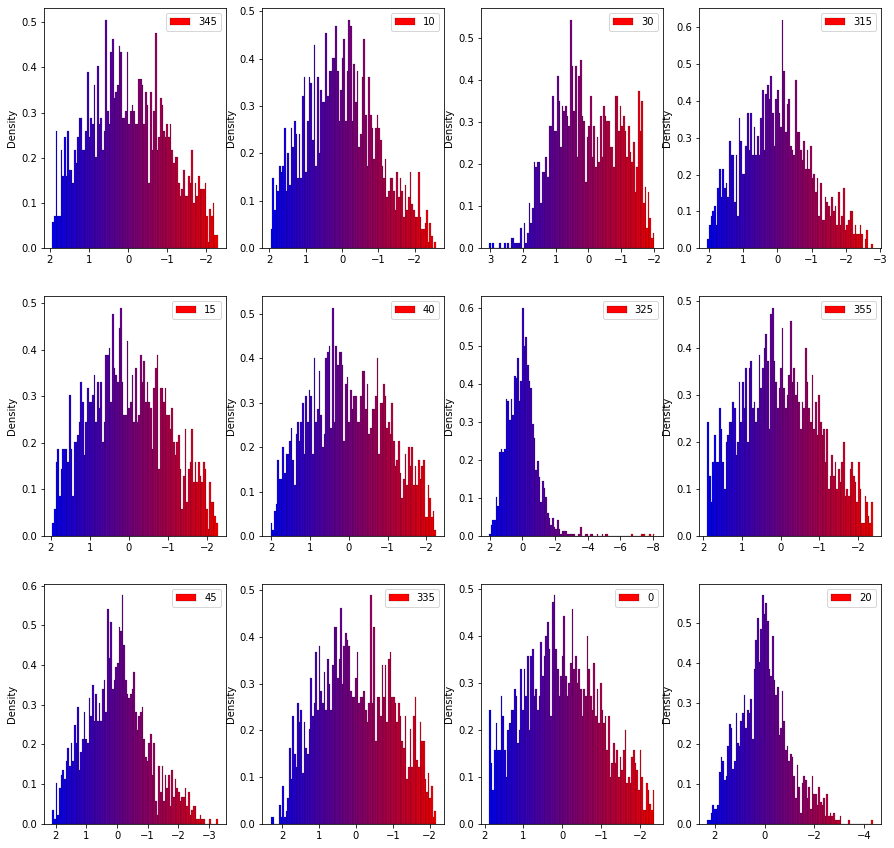

In [ ]:
f, ax = plt.subplots(3, 4, figsize=(15,15))
angles=[315,325,335,345,355,0,10,15,20,30,40,45]
for i in range(len(angles)):
    sn.histplot(tests[angles[i]],ax=ax[i % 3,(11-i)%4],kde=False,legend=False,bins=100,stat='density',label=angles[i])
    for j in range(0,100):
        ax[i%3,(11-i)%4].patches[j].set_facecolor([1-j/100,0,j/100])
#sn.kdeplot(flat_test,ax=ax,color='orange')
    
    ax[i%3,(11-i)%4].invert_xaxis()
    ax[i%3,(11-i)%4].legend()

plt.show()

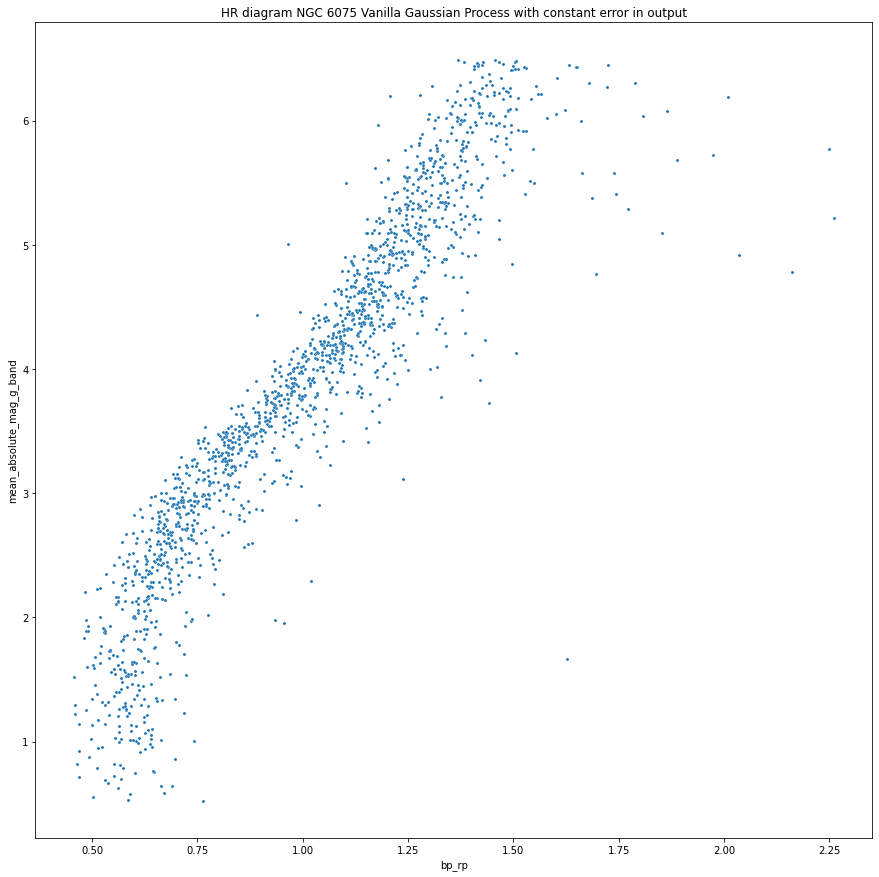

In [ ]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15,15))

    sn.scatterplot(data=orig_scatter,x='bp_rp',y='mean_absolute_mag_g_band',s=10)
    
    
    # Plot predictive means as blue line
    
    
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

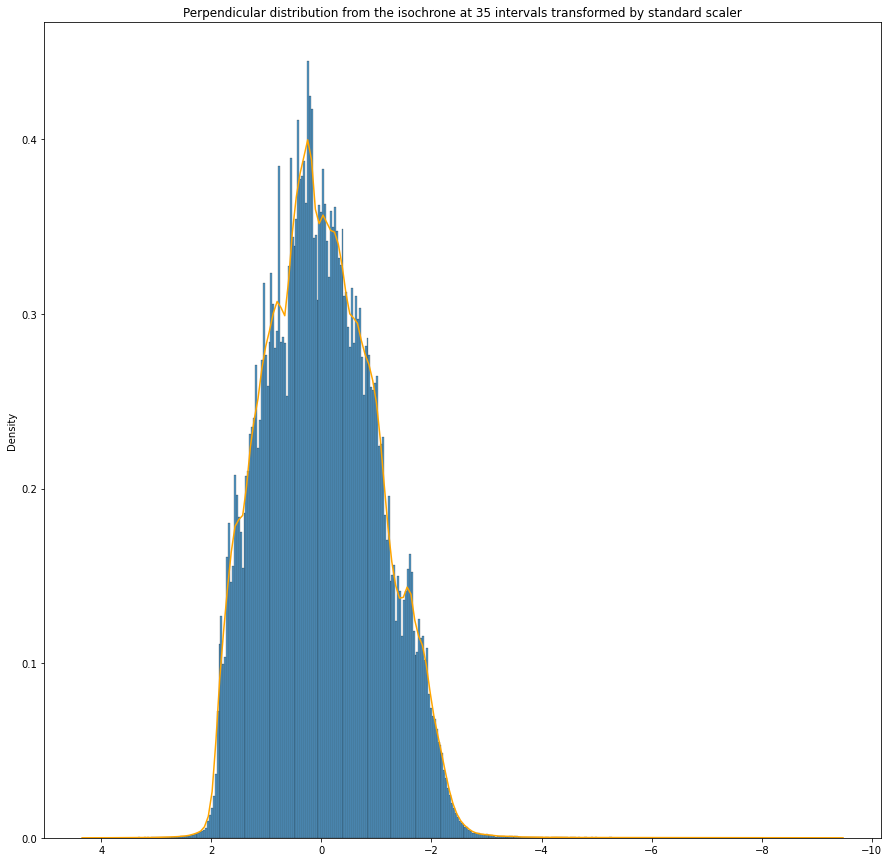

In [ ]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(flat_test,ax=ax,kde=False,legend=False,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(flat_test,ax=ax,color='orange')
ax.invert_xaxis()
plt.show()